In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras


data = pd.read_csv("R.csv")

2023-06-16 00:25:09.053658: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-16 00:25:09.165553: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 00:25:09.772828: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 00:25:09.783108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 00:25:12.008491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
labels = data.copy()

feature_headings = [
    "d1","d2","d3","d4","d5","d6","First Layer","Second Layer"
]

features = labels[feature_headings]
labels = labels[[c for c in labels.columns if c not in feature_headings]]


In [3]:
materials = list(set([*features["First Layer"].unique(), *features["Second Layer"].unique()]))

mapping = {
    v: i for (i,v) in enumerate(materials)
}

features["First Layer"] = features["First Layer"].apply(lambda x: mapping[x])
features["Second Layer"] = features["Second Layer"].apply(lambda x: mapping[x])


feature_array = np.array(features)
feature_array

array([[30, 40, 60, ..., 40, 24, 12],
       [50, 50, 50, ..., 50,  2,  4],
       [20, 10, 60, ..., 60,  0, 19],
       ...,
       [40, 20, 30, ..., 30,  2,  9],
       [40, 40, 50, ..., 40, 26, 14],
       [60, 60, 10, ..., 30,  3, 21]])

In [46]:
ml_model = keras.Sequential([
   
    keras.layers.Dense(8,activation="relu"),
    keras.layers.Dropout(.5),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dropout(.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(.5),
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dense(len(labels.columns),activation="sigmoid")
])

ml_model.compile(loss= keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())

In [47]:
ml_model.fit(features, labels, epochs=10, validation_split=0.1)

Epoch 1/10
844/844 [==============================] - 6s 5ms/step - loss: 0.1232 - val_loss: 0.1158
Epoch 2/10
844/844 [==============================] - 5s 6ms/step - loss: 0.1180 - val_loss: 0.1157
Epoch 3/10
844/844 [==============================] - 5s 6ms/step - loss: 0.1180 - val_loss: 0.1157
Epoch 4/10
844/844 [==============================] - 5s 6ms/step - loss: 0.1180 - val_loss: 0.1158
Epoch 5/10
844/844 [==============================] - 5s 6ms/step - loss: 0.1180 - val_loss: 0.1157
Epoch 6/10
844/844 [==============================] - 5s 5ms/step - loss: 0.1180 - val_loss: 0.1158
Epoch 7/10
844/844 [==============================] - 6s 8ms/step - loss: 0.1180 - val_loss: 0.1157
Epoch 8/10
844/844 [==============================] - 6s 7ms/step - loss: 0.1180 - val_loss: 0.1158
Epoch 9/10
844/844 [==============================] - 6s 7ms/step - loss: 0.1180 - val_loss: 0.1157
Epoch 10/10
844/844 [==============================] - 4s 5ms/step - loss: 0.1180 - val_loss: 0.1158

In [6]:
materials_to_use = mapping["SiO2"], mapping["Co"]

1/1 [==============================] - 0s 114ms/step


/root/repos/l2-transfer-matrix-method/.venv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


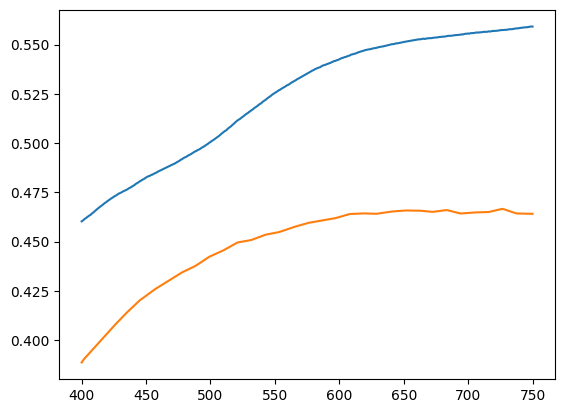

In [48]:
from transfer_matrix_method import reflectance
from transfer_matrix_method.reflectance import Layer
from transfer_matrix_method.refractive_index import MaterialRefractiveIndex
import matplotlib.pyplot as plt

sio2 = MaterialRefractiveIndex("SiO2")
Co = MaterialRefractiveIndex("Co")

spec = [10,10,10,20,20,20, *materials_to_use[::-1]]

layers = [Layer(t*1e-9, MaterialRefractiveIndex(materials[spec[6:][i%2]])) for t,i in enumerate(spec[:6])]

x = np.arange(400,751,1)
y1 = ml_model.predict([spec]).T
y2 = [reflectance(layers,x_i*1e-9)["reflectance"] for x_i in x]

fig,ax = plt.subplots()

ax.plot(x,list(zip(y1,y2)))